# RIBBIT analysis
## Case Study 1: Boreal chorus frog 

This notebook shows the analysis that was performed for Case Study 1. We detect chorus frogs in ARU recordings from Montana, USA using RIBBIT. In this notebook, we analyze a small subset of 5 files for the purpose of demonstration.

RIBBIT is available in Pythoon in the package [OpenSoundscape](https://opensoundscape.org) and in R using [this script](url). This notebook was tested with OpenSoundscape [v0.4.4](https://github.com/kitzeslab/opensoundscape/releases/tag/v0.4.4). 

For more information on the open-source RIBBIT tool, or for help installing OpenSoundscape, see the [documentation](https://opensoundscape.org). 

### import packages

In [8]:
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import os

from opensoundscape.ribbit import ribbit
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram

plt.rcParams['figure.figsize']=[15,8] #for big visuals
%config InlineBackend.figure_format = 'retina'

### choose audio files to analyze

In [2]:
audio_files = glob('./audio/chorus_frog_field_data/*')

### select model parameters

RIBBIT requires the user to select a set of parameters that describe the target vocalization. Here we use the parameters which produced the results reported in the manuscript

**spectrogram and audio parameters**

In [3]:
#audio sampling rate
sample_rate = 32000 

#number of samples per spectrogram window
spec_window_samples = 256

#number of overlapping samples between consecutive spectrogram windows
spec_overlap_samples = 0 

**RIBBIT parameters**

In [4]:
# minimum and maximum rate of pulsing (pulses per second) to search for
pulse_rate_range = [13,30] 

# look for a vocalization in the range of 1000-2000 Hz 
signal_band = [1000,3300] 

# subtract the amplitude signal from these frequency ranges
noise_bands = [ [100,1000], [1800,2500]] 

#divides the signal into segments this many seconds long, analyzes each independently
window_length = 2 #(seconds) 

#if True, it will show the power spectrum plot for each audio segment 
show_plots = False 

#take lowest of continuity_filter_windows consecutive scores
#(if 1, has no effect)
continuity_filter_windows = 10

## search for pulsing vocalizations with `ribbit()` 

The `analyze` function below takes a file path, performs the RIBBIT analysis, and returns the highest RIBBIT score for the file along with the time of that score sicne the beginning of the file.

The `continuity_filter` function takes a set of consecutive scores from a file, and keeps only the highest of n scores in a moving window of length n. This is useful for detecting continuous choruses such as that of the chorus frog, while rejecting short vocalizations of similar repetition rate. 

In [5]:
def continuity_filter(scores,n_windows):
    '''returns an array z where the element z[i] is the minimum of x[i:i+n_windows] for i in [0,len(x)-n_windows+1]'''
    if n_windows==1:
        return scores
    if len(scores) < n_windows:
        raise ValueError('length of scores must be at least n_windows')
    z = np.zeros(len(scores)-n_windows + 1)
    for i in range(len(z)):
        z[i] = min(scores[i:i+n_windows])
    return z

In [6]:
def analyze(path):
    '''run RIBBIT on an audio file
    
    args: 
        path to audio file (.wav, .mp3, etc)
    return: 
        the maximum RIBBIT score on the file, and
        the time of that score since the beginning of the file (seconds)
    '''
    
    #make a spectrogram for the file
    audio = Audio.from_file(path,
                            sample_rate=sample_rate)
    spec = Spectrogram.from_audio(audio,
                                 window_samples=spec_window_samples,
                                 overlap_samples=spec_overlap_samples)

    #run RIBBIT
    scores, times =  ribbit(
                        spec,
                        pulse_rate_range=pulse_rate_range,
                        signal_band=signal_band,
                        window_len=window_length,
                        noise_bands=noise_bands,
                        plot=False)

    #apply continuity filter (keep only the lowest of n consecutive scores)
    filtered_scores = continuity_filter(scores,continuity_filter_windows)
    filtered_times = times[:len(filtered_scores)] 
    
    #return the maximum score and the time it occurred
    return (max(filtered_scores),filtered_times[np.argmax(filtered_scores)])

#### calculate scores

In [10]:
# set up a dataframe for storing files' scores and labels
df = pd.DataFrame(index = audio_files, columns=['score','time'])

# calculate RIBBIT scores
for path in df.index:

    score, time_max_score = analyze(path)

    # use the maximum RIBBIT score from any window as the score for this file
    df.at[path,'score'] = score
    df.at[path,'time'] = time_max_score

/Users/sml161/Library/Caches/pypoetry/virtualenvs/opensoundscape-6-tAnDaV-py3.7/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))
/Users/sml161/Library/Caches/pypoetry/virtualenvs/opensoundscape-6-tAnDaV-py3.7/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))
/Users/sml161/Library/Caches/pypoetry/virtualenvs/opensoundscape-6-tAnDaV-py3.7/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))
/Users/sml161/Library/Caches/pypoetry/virtualenvs/opensoundscape-6-tAnDaV-py3.7/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .for

#### view results

In [21]:
# make scores easier to read
df['score e-5']=[np.round(s*1e5,2) for s in df.score]
df.index = [os.path.basename(f) for f in df.index]
df['time']= [round(t) for t in df['time']]

print("Files sorted by score, from highest to lowest \nwith time in seconds where highest score occurred")
df[['score e-5','time']].sort_values(by='score e-5',ascending=False)

Files sorted by score, from highest to lowest 
with time in seconds where highest score occurred


,score e-5,time
chorus_frogs_and_coyotes.wav,2.35,6
chorus_frogs.wav,2.16,6
birds.wav,1.04,0
great_plains_toad.wav,0.68,8
popping.wav,0.03,0


## view spectrograms of each file

birds.wav


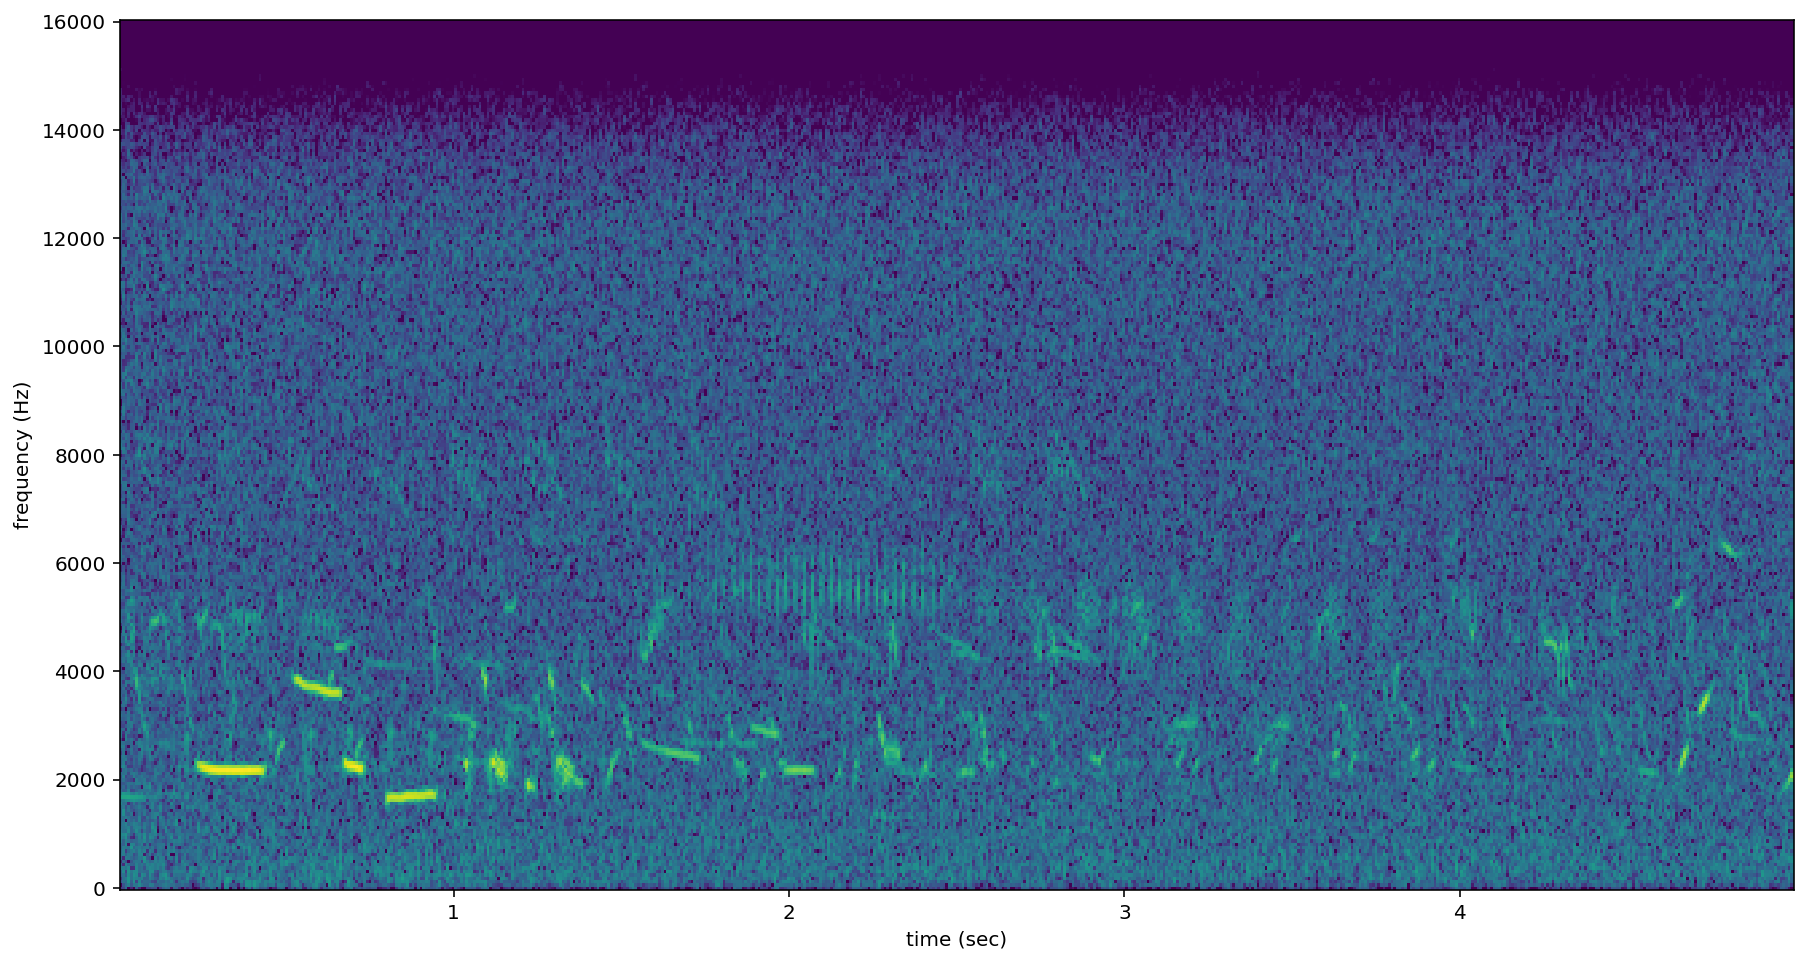

chorus_frogs.wav


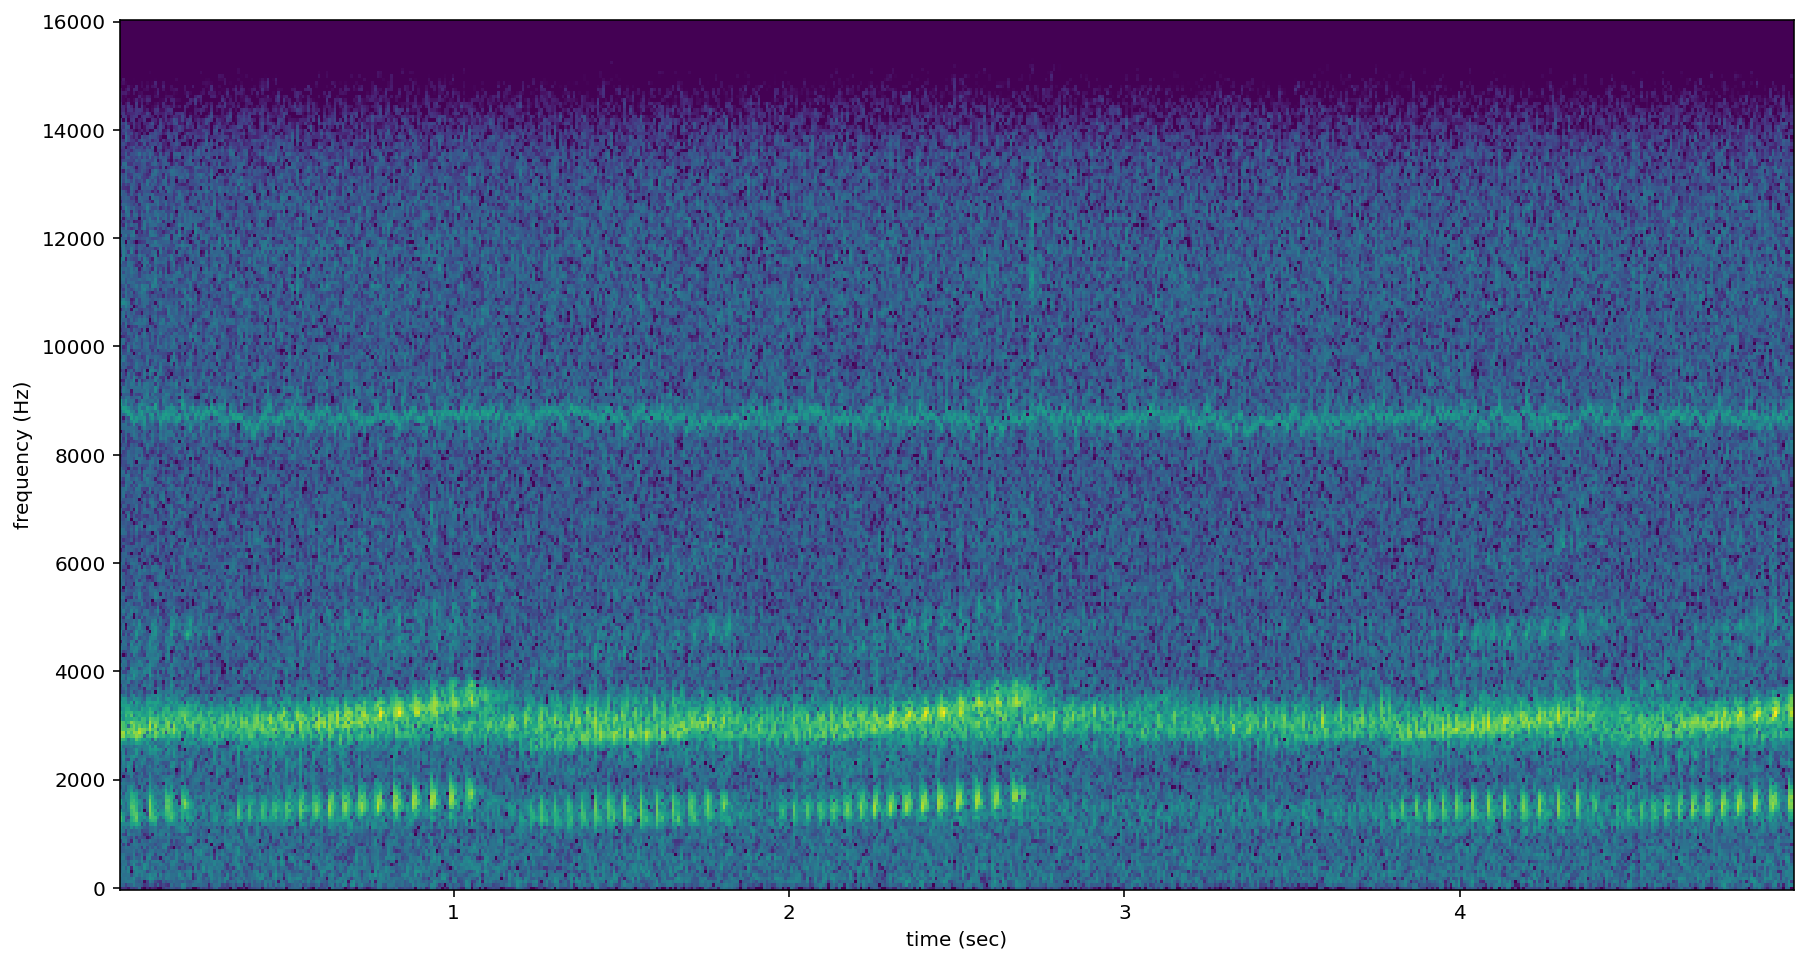

chorus_frogs_and_coyotes.wav


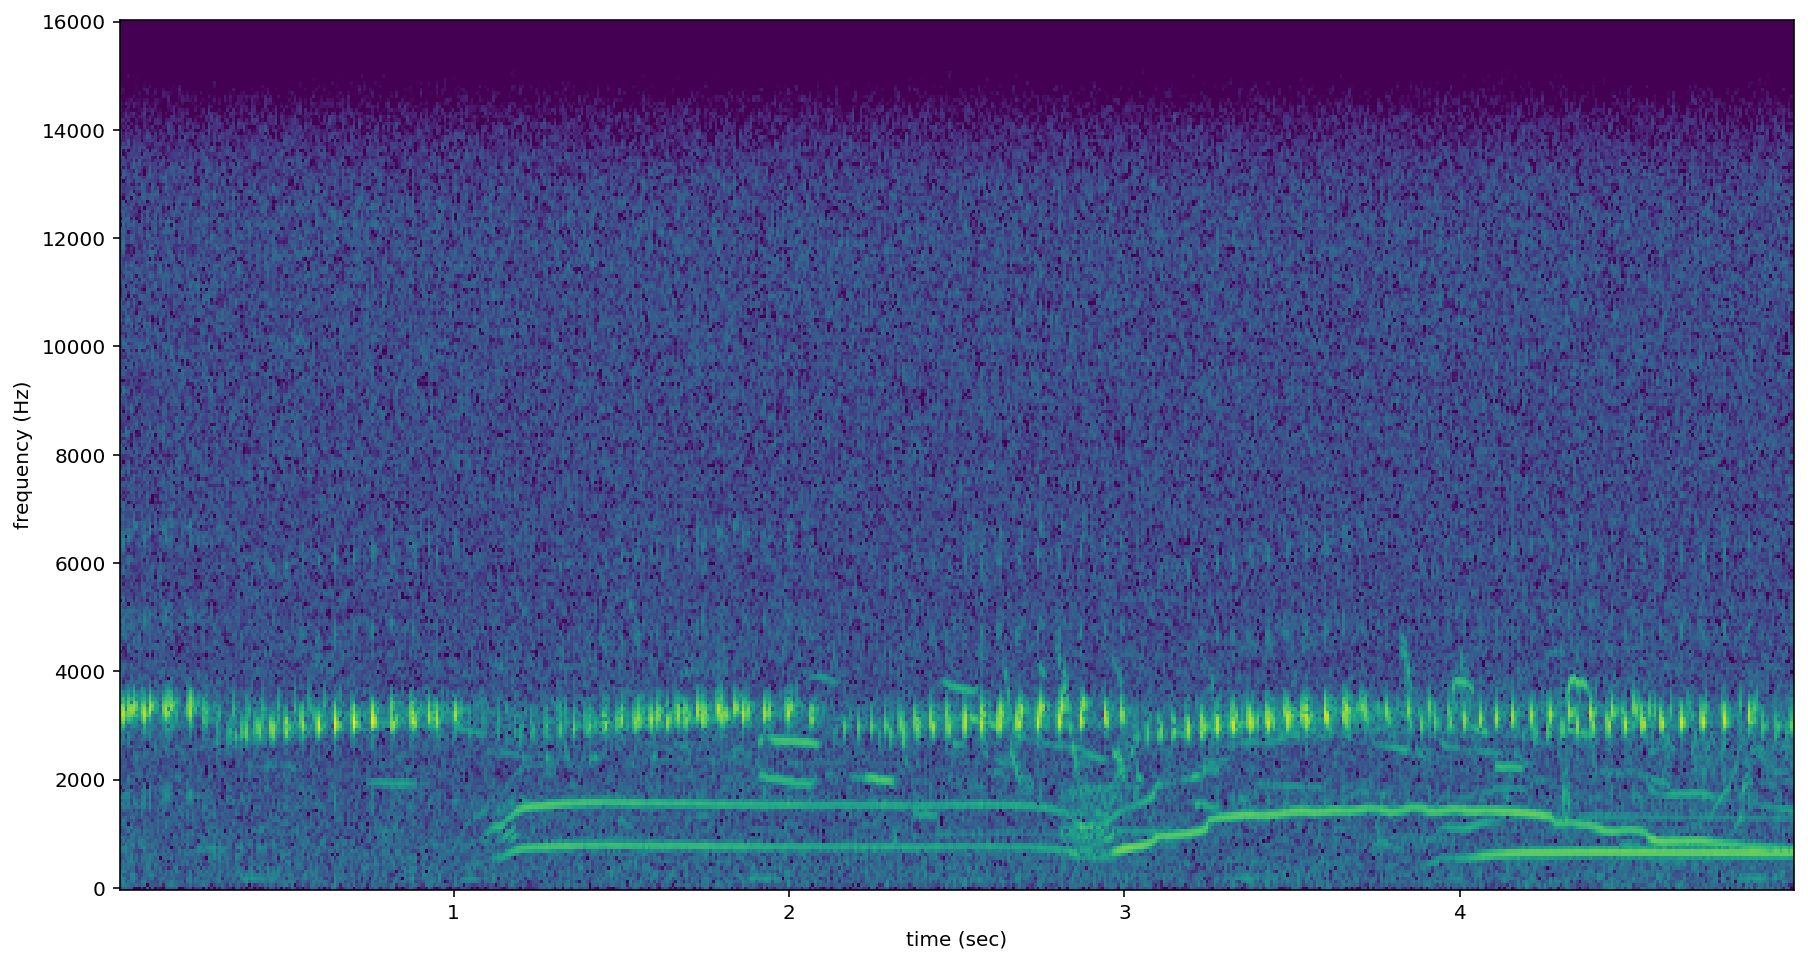

great_plains_toad.wav


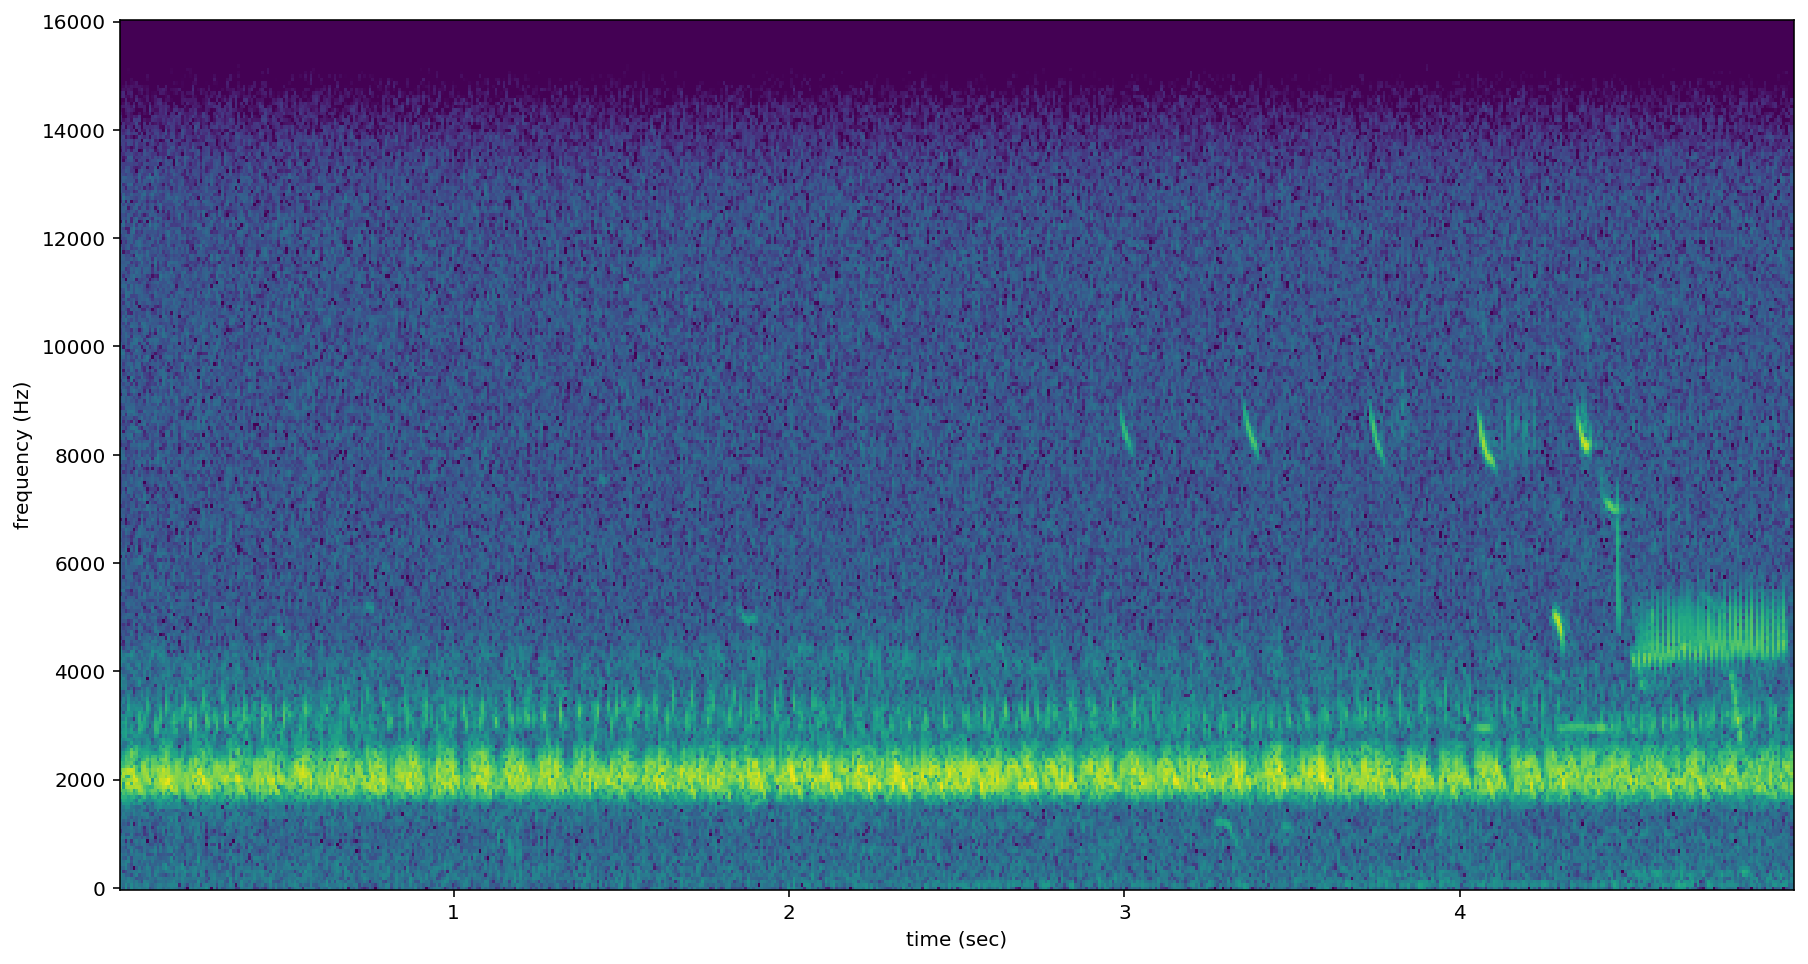

popping.wav


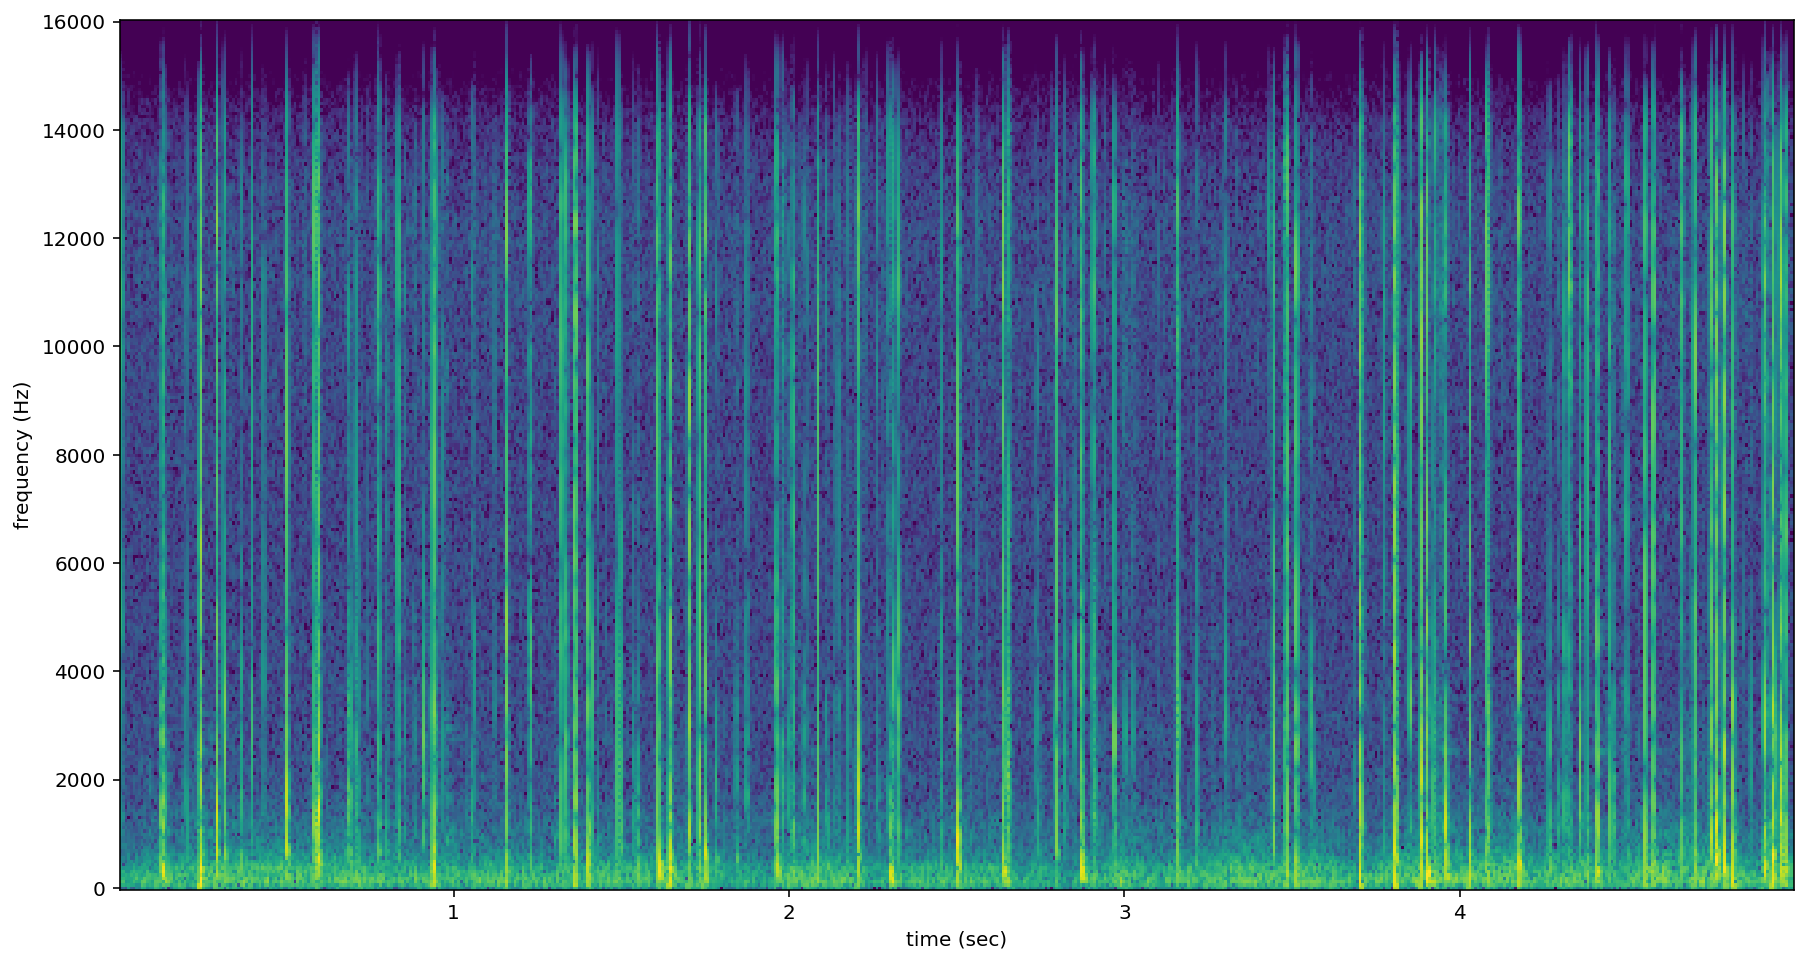

In [18]:
for f in audio_files:
    print(os.path.basename(f))
    Spectrogram.from_audio(Audio.from_file(f,sample_rate=32000).trim(0,5)).plot()